<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/seblock_50epoch_flower_D_se_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 10.6 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 85.6MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf, se = True )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, se = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, se = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:45<00:00,  1.02s/it]


epoch: 0, lossD:0.752804463548423, lossG:12.14542219939741,lossG_fake:8.483389166952337, lossG_real:3.662033005246838 ,equality:4.8213561617054985


evaluate:122.97792053222656,kid_mean:0.07894439995288849, kid_std:0.01876477710902691,kid_:(tensor(0.0789), tensor(0.0188))


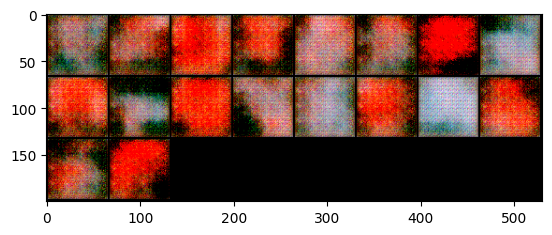

100%|██████████| 103/103 [00:09<00:00, 11.15it/s]


epoch: 1, lossD:0.6700341438567176, lossG:7.166160852006338,lossG_fake:4.140122781679469, lossG_real:3.0260380720629274 ,equality:1.1140847096165412


evaluate:123.67308044433594,kid_mean:0.08503773808479309, kid_std:0.03303486853837967,kid_:(tensor(0.0850), tensor(0.0330))


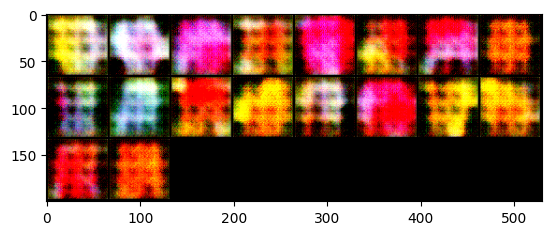

100%|██████████| 103/103 [00:09<00:00, 11.33it/s]


epoch: 2, lossD:0.9618588450174888, lossG:6.028992652893066,lossG_fake:3.4539435858865386, lossG_real:2.5750490690319285 ,equality:0.8788945168546101


evaluate:122.7540283203125,kid_mean:0.08423057198524475, kid_std:0.04026983678340912,kid_:(tensor(0.0842), tensor(0.0403))


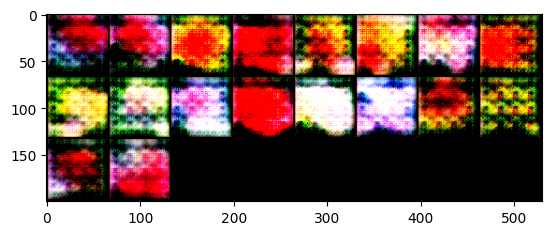

100%|██████████| 103/103 [00:09<00:00, 11.23it/s]


epoch: 3, lossD:1.045487015571409, lossG:6.087917605650078,lossG_fake:3.691387108228739, lossG_real:2.396530497710682 ,equality:1.2948566105180572


evaluate:118.34841918945312,kid_mean:0.07645194977521896, kid_std:0.03506825864315033,kid_:(tensor(0.0765), tensor(0.0351))


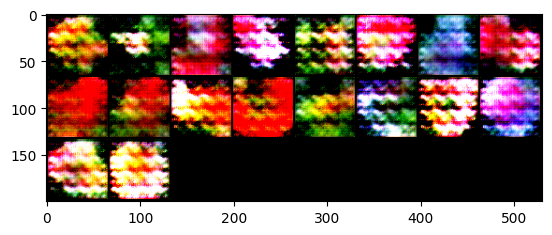

100%|██████████| 103/103 [00:09<00:00, 11.08it/s]


epoch: 4, lossD:0.9013495997896472, lossG:6.196403711744883,lossG_fake:3.695424427685228, lossG_real:2.5009792782727955 ,equality:1.1944451494124326


evaluate:115.45808410644531,kid_mean:0.07705941796302795, kid_std:0.03661732003092766,kid_:(tensor(0.0771), tensor(0.0366))


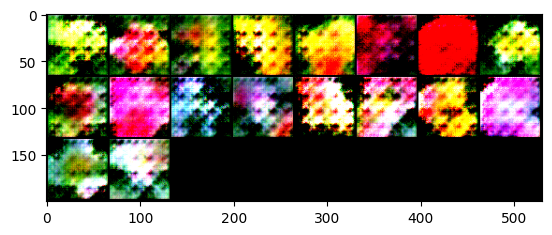

100%|██████████| 103/103 [00:09<00:00, 11.20it/s]


epoch: 5, lossD:0.9223819204325815, lossG:5.983319009392007,lossG_fake:3.5503970986431086, lossG_real:2.432921904383354 ,equality:1.1174751942597547


evaluate:122.76691436767578,kid_mean:0.08403194695711136, kid_std:0.0425955131649971,kid_:(tensor(0.0840), tensor(0.0426))


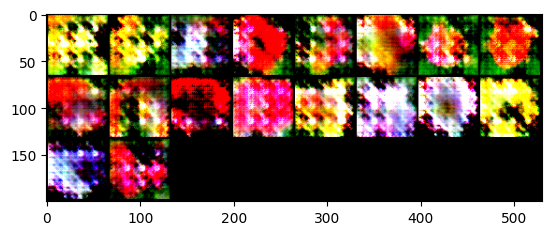

100%|██████████| 103/103 [00:09<00:00, 11.10it/s]


epoch: 6, lossD:0.9523366887881918, lossG:5.862451507049856,lossG_fake:3.440817265834623, lossG_real:2.421634218067799 ,equality:1.0191830477668242


evaluate:122.38939666748047,kid_mean:0.08786806464195251, kid_std:0.04004766419529915,kid_:(tensor(0.0879), tensor(0.0400))


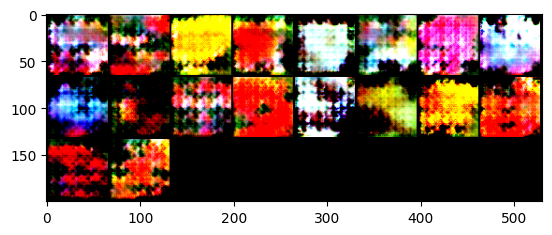

100%|██████████| 103/103 [00:09<00:00, 11.15it/s]


epoch: 7, lossD:0.960233783837661, lossG:5.8132437872655185,lossG_fake:3.408337075733444, lossG_real:2.4049067277352787 ,equality:1.0034303479981652


evaluate:119.0076675415039,kid_mean:0.07902278751134872, kid_std:0.03793535754084587,kid_:(tensor(0.0790), tensor(0.0379))


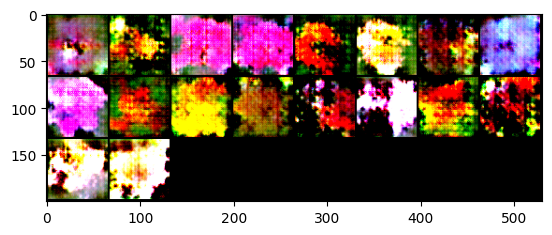

100%|██████████| 103/103 [00:08<00:00, 11.66it/s]


epoch: 8, lossD:0.9945389009216457, lossG:5.620612649084295,lossG_fake:3.278856660555867, lossG_real:2.341755973482595 ,equality:0.9371006870732721


evaluate:120.48065185546875,kid_mean:0.0803169533610344, kid_std:0.043836768716573715,kid_:(tensor(0.0803), tensor(0.0438))


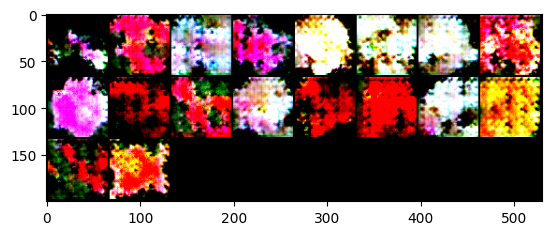

100%|██████████| 103/103 [00:09<00:00, 11.36it/s]


epoch: 9, lossD:1.0172940981619567, lossG:5.424913684141289,lossG_fake:3.1130008165118763, lossG_real:2.3119128852793316 ,equality:0.8010879312325447


evaluate:122.03204345703125,kid_mean:0.08749102801084518, kid_std:0.038793593645095825,kid_:(tensor(0.0875), tensor(0.0388))


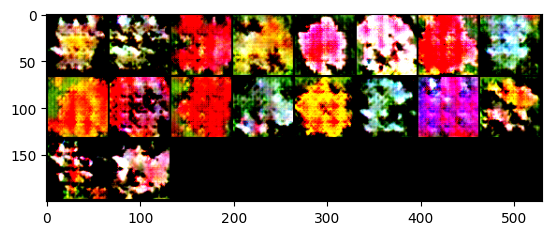

100%|██████████| 103/103 [00:09<00:00, 11.15it/s]


epoch: 10, lossD:1.124453671927591, lossG:5.061777536151479,lossG_fake:2.8747811687802804, lossG_real:2.186996354350766 ,equality:0.6877848144295147


evaluate:115.69625091552734,kid_mean:0.08536063134670258, kid_std:0.039629895240068436,kid_:(tensor(0.0854), tensor(0.0396))


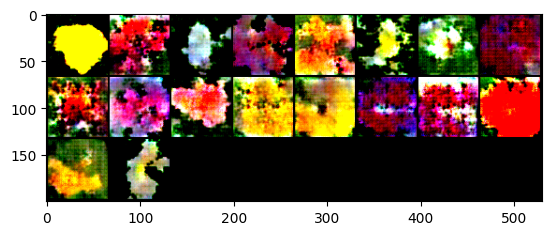

100%|██████████| 103/103 [00:09<00:00, 10.95it/s]


epoch: 11, lossD:1.1067122717216178, lossG:5.00659356996851,lossG_fake:2.852363295925474, lossG_real:2.1542302890888694 ,equality:0.6981330068366045


evaluate:113.15261840820312,kid_mean:0.07856981456279755, kid_std:0.03985185921192169,kid_:(tensor(0.0786), tensor(0.0399))


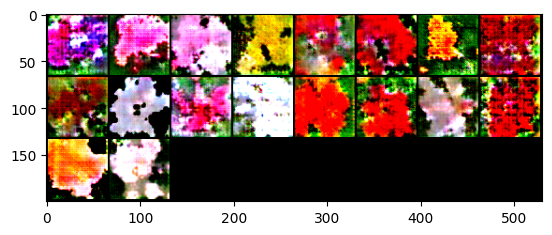

100%|██████████| 103/103 [00:09<00:00, 11.44it/s]


epoch: 12, lossD:1.1563563485747401, lossG:4.899844956629485,lossG_fake:2.7605604326840743, lossG_real:2.139284524524096 ,equality:0.6212759081599781


evaluate:116.06251525878906,kid_mean:0.08467921614646912, kid_std:0.04448847472667694,kid_:(tensor(0.0847), tensor(0.0445))


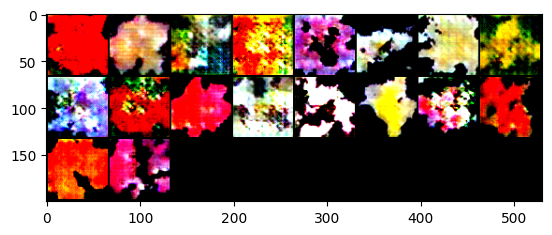

100%|██████████| 103/103 [00:08<00:00, 11.65it/s]


epoch: 13, lossD:1.1313092129901774, lossG:5.006384011611198,lossG_fake:2.7974446132345108, lossG_real:2.208939371757137 ,equality:0.5885052414773737


evaluate:107.0447006225586,kid_mean:0.07888773083686829, kid_std:0.041507914662361145,kid_:(tensor(0.0789), tensor(0.0415))


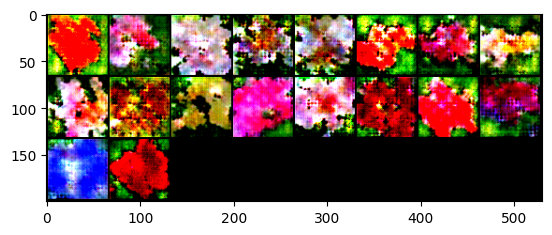

100%|██████████| 103/103 [00:09<00:00, 11.14it/s]


epoch: 14, lossD:1.0878615955125939, lossG:4.966558287444624,lossG_fake:2.7980573408811997, lossG_real:2.168500934989707 ,equality:0.6295564058914929


evaluate:105.76947021484375,kid_mean:0.07424846291542053, kid_std:0.03950151801109314,kid_:(tensor(0.0742), tensor(0.0395))


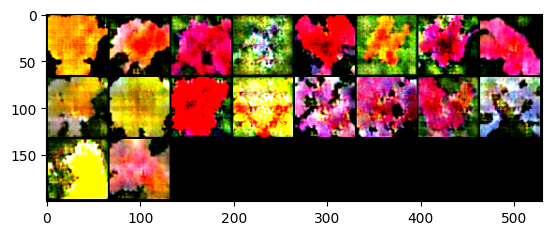

100%|██████████| 103/103 [00:09<00:00, 11.10it/s]


epoch: 15, lossD:1.0985848944164016, lossG:5.066030854160346,lossG_fake:2.789187516980958, lossG_real:2.2768433284990994 ,equality:0.5123441884818587


evaluate:104.21593475341797,kid_mean:0.06989705562591553, kid_std:0.036765310913324356,kid_:(tensor(0.0699), tensor(0.0368))


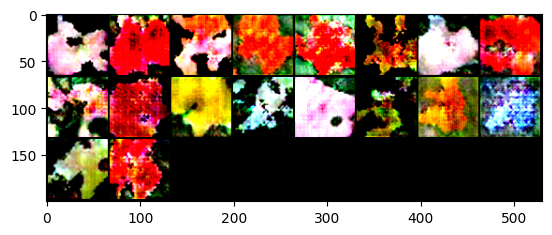

100%|██████████| 103/103 [00:09<00:00, 11.05it/s]


epoch: 16, lossD:1.0387978145798433, lossG:5.118367084021707,lossG_fake:2.828236230368753, lossG_real:2.290130890110164 ,equality:0.5381053402585891


evaluate:109.21843719482422,kid_mean:0.06602119654417038, kid_std:0.035069119185209274,kid_:(tensor(0.0660), tensor(0.0351))


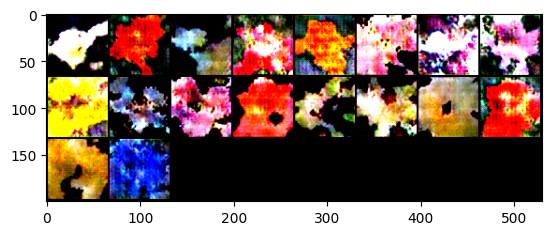

100%|██████████| 103/103 [00:09<00:00, 11.21it/s]


epoch: 17, lossD:0.9123842881142514, lossG:5.331147337422787,lossG_fake:2.872051274892196, lossG_real:2.4590960810485396 ,equality:0.4129551938436564


evaluate:110.92705535888672,kid_mean:0.07681597024202347, kid_std:0.04043697565793991,kid_:(tensor(0.0768), tensor(0.0404))


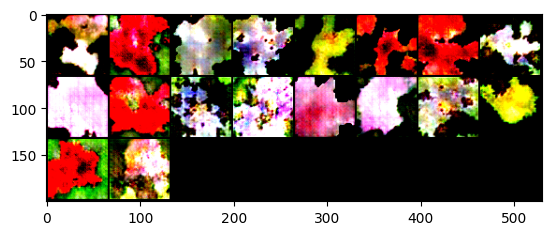

100%|██████████| 103/103 [00:08<00:00, 11.46it/s]


epoch: 18, lossD:0.8852302996278967, lossG:5.457490698805133,lossG_fake:2.9661607991144496, lossG_real:2.4913298962185686 ,equality:0.47483090289588104


evaluate:111.74312591552734,kid_mean:0.07854766398668289, kid_std:0.04127705469727516,kid_:(tensor(0.0785), tensor(0.0413))


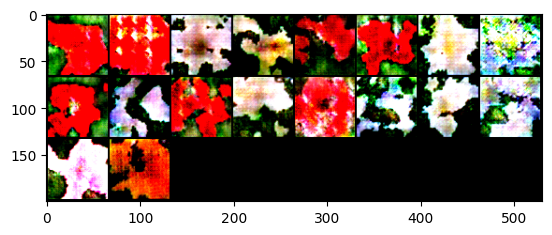

100%|██████████| 103/103 [00:09<00:00, 11.31it/s]


epoch: 19, lossD:0.8889567363030703, lossG:5.5296424106486795,lossG_fake:2.9988389929521433, lossG_real:2.5308034327423687 ,equality:0.46803556020977455


evaluate:112.25833129882812,kid_mean:0.07382947951555252, kid_std:0.04416677728295326,kid_:(tensor(0.0738), tensor(0.0442))


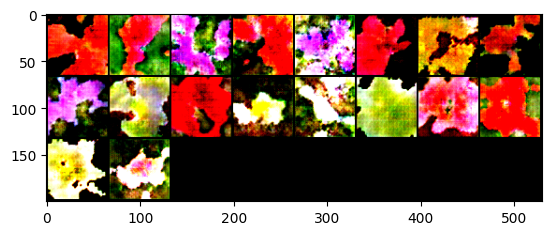

100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


epoch: 20, lossD:0.6367390902297011, lossG:5.915091084045114,lossG_fake:3.184959550505703, lossG_real:2.7301315393262695 ,equality:0.4548280111794334


evaluate:112.1775894165039,kid_mean:0.07480084151029587, kid_std:0.04192633926868439,kid_:(tensor(0.0748), tensor(0.0419))


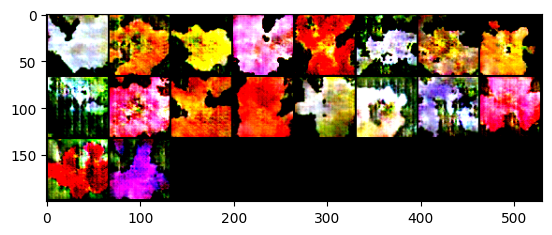

100%|██████████| 103/103 [00:09<00:00, 11.03it/s]


epoch: 21, lossD:0.631464011750175, lossG:6.060848601813455,lossG_fake:3.3339744470651866, lossG_real:2.726874157641698 ,equality:0.6071002894234887


evaluate:113.84147644042969,kid_mean:0.08000954985618591, kid_std:0.04115245118737221,kid_:(tensor(0.0800), tensor(0.0412))


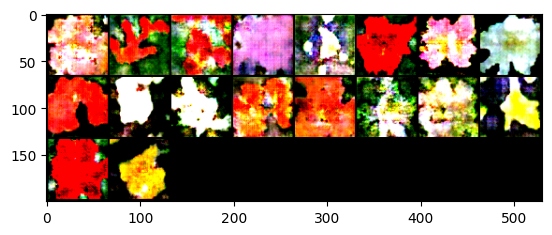

100%|██████████| 103/103 [00:09<00:00, 11.27it/s]


epoch: 22, lossD:0.5970695664003057, lossG:6.256706742407049,lossG_fake:3.406208362972852, lossG_real:2.850498360337563 ,equality:0.5557100026352892


evaluate:113.34502410888672,kid_mean:0.07250496000051498, kid_std:0.040534403175115585,kid_:(tensor(0.0725), tensor(0.0405))


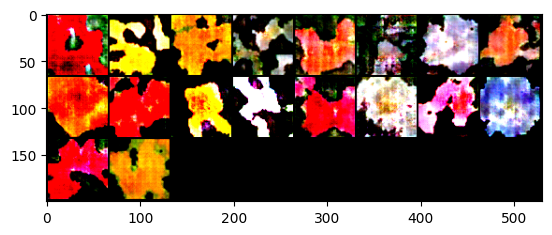

100%|██████████| 103/103 [00:09<00:00, 11.37it/s]


epoch: 23, lossD:0.4709035009869094, lossG:6.37483413011125,lossG_fake:3.37361861895589, lossG_real:3.0012155180995905 ,equality:0.3724031008562996


evaluate:112.58452606201172,kid_mean:0.07547445595264435, kid_std:0.03845878690481186,kid_:(tensor(0.0755), tensor(0.0385))


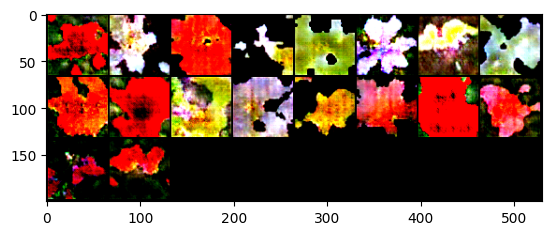

100%|██████████| 103/103 [00:09<00:00, 11.08it/s]


epoch: 24, lossD:0.5085943415760994, lossG:6.5326089071996005,lossG_fake:3.485873200939697, lossG_real:3.046735712625448 ,equality:0.43913748831424915


evaluate:112.6112289428711,kid_mean:0.07655740529298782, kid_std:0.03683800995349884,kid_:(tensor(0.0766), tensor(0.0368))


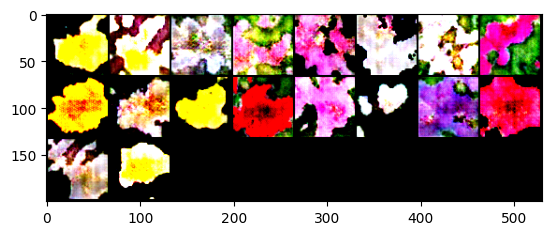

100%|██████████| 103/103 [00:09<00:00, 10.89it/s]


epoch: 25, lossD:0.42138801668815823, lossG:6.807566902012501,lossG_fake:3.659799647562712, lossG_real:3.1477672799119674 ,equality:0.5120323676507446


evaluate:110.21541595458984,kid_mean:0.07524281740188599, kid_std:0.04050624370574951,kid_:(tensor(0.0752), tensor(0.0405))


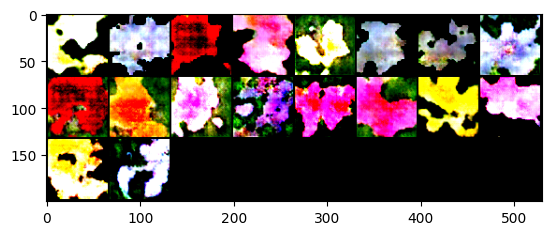

100%|██████████| 103/103 [00:09<00:00, 10.97it/s]


epoch: 26, lossD:0.338227640276829, lossG:6.949900492881108,lossG_fake:3.723245841785542, lossG_real:3.2266546499381943 ,equality:0.4965911918473478


evaluate:108.6445541381836,kid_mean:0.06376400589942932, kid_std:0.03139214590191841,kid_:(tensor(0.0638), tensor(0.0314))


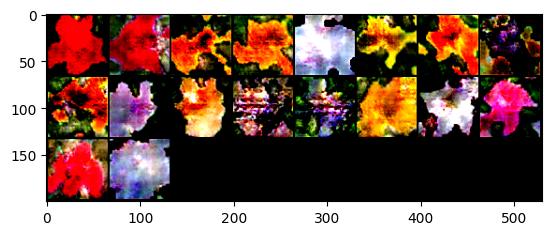

100%|██████████| 103/103 [00:08<00:00, 11.50it/s]


epoch: 27, lossD:0.41181680205666904, lossG:6.8540245722798465,lossG_fake:3.61601776347577, lossG_real:3.238006790864815 ,equality:0.37801097261095506


evaluate:109.82305908203125,kid_mean:0.07023752480745316, kid_std:0.03908671438694,kid_:(tensor(0.0702), tensor(0.0391))


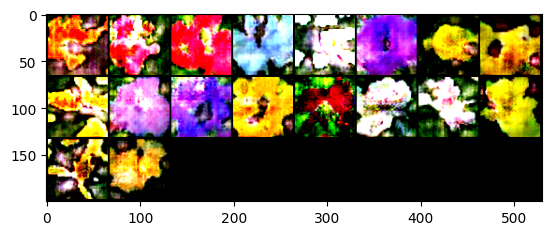

100%|██████████| 103/103 [00:09<00:00, 11.24it/s]


epoch: 28, lossD:0.37871612821823186, lossG:7.029423306289228,lossG_fake:3.7214131991840103, lossG_real:3.308010120993679 ,equality:0.4134030781903313


evaluate:110.67634582519531,kid_mean:0.0710810124874115, kid_std:0.04130604490637779,kid_:(tensor(0.0711), tensor(0.0413))


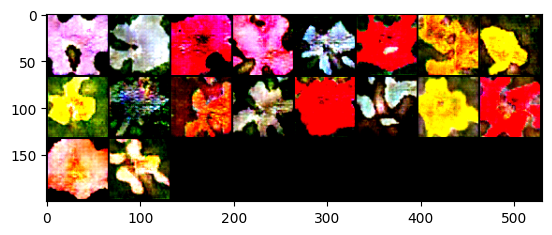

100%|██████████| 103/103 [00:09<00:00, 10.73it/s]


epoch: 29, lossD:0.24489483474166068, lossG:7.195367239053967,lossG_fake:3.816962091668138, lossG_real:3.3784051659037764 ,equality:0.4385569257643618


evaluate:111.07311248779297,kid_mean:0.06506168097257614, kid_std:0.03893065080046654,kid_:(tensor(0.0651), tensor(0.0389))


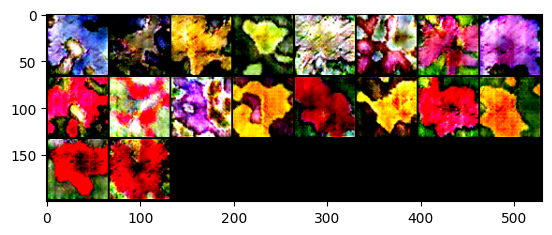

100%|██████████| 103/103 [00:09<00:00, 11.21it/s]


epoch: 30, lossD:0.36437000741151354, lossG:7.442226521019797,lossG_fake:4.019643457190504, lossG_real:3.422583039524486 ,equality:0.5970604176660186


evaluate:112.52116394042969,kid_mean:0.07154656201601028, kid_std:0.037045035511255264,kid_:(tensor(0.0715), tensor(0.0370))


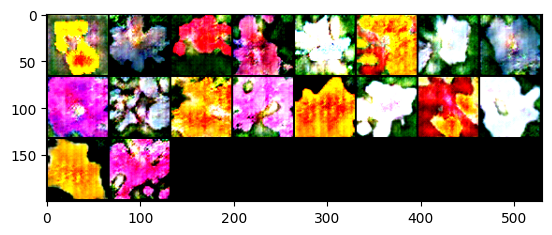

100%|██████████| 103/103 [00:09<00:00, 10.99it/s]


epoch: 31, lossD:0.3175014224337432, lossG:7.5710002334372515,lossG_fake:4.071387036332807, lossG_real:3.499613214465021 ,equality:0.5717738218677857


evaluate:112.79829406738281,kid_mean:0.07775341719388962, kid_std:0.038226231932640076,kid_:(tensor(0.0778), tensor(0.0382))


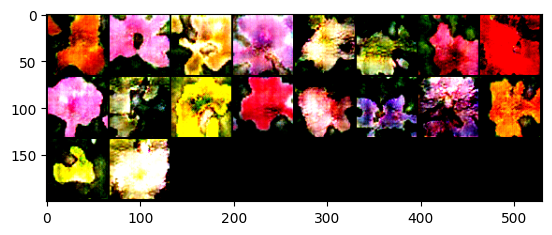

100%|██████████| 103/103 [00:09<00:00, 11.33it/s]


epoch: 32, lossD:0.2991589741437759, lossG:7.590138245554804,lossG_fake:4.118265276973688, lossG_real:3.4718729888351216 ,equality:0.646392288138566


evaluate:112.89799499511719,kid_mean:0.08145199716091156, kid_std:0.04655268415808678,kid_:(tensor(0.0815), tensor(0.0466))


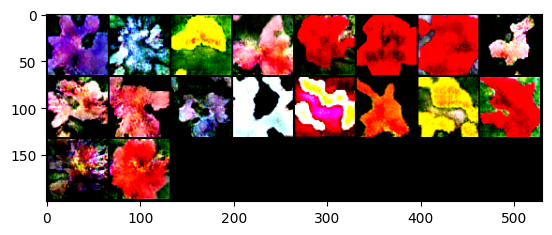

100%|██████████| 103/103 [00:09<00:00, 11.18it/s]


epoch: 33, lossD:0.2897567473424291, lossG:7.688044742473121,lossG_fake:4.072886979695663, lossG_real:3.615157759305343 ,equality:0.4577292203903198


evaluate:112.48348236083984,kid_mean:0.07620920985937119, kid_std:0.04110490530729294,kid_:(tensor(0.0762), tensor(0.0411))


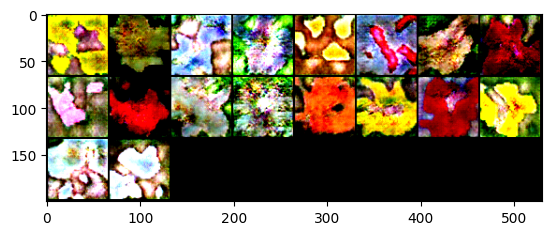

100%|██████████| 103/103 [00:09<00:00, 11.14it/s]


epoch: 34, lossD:0.22014401549274482, lossG:7.937939625341915,lossG_fake:4.223056619607129, lossG_real:3.714882994161069 ,equality:0.50817362544606


evaluate:113.14051818847656,kid_mean:0.07386697828769684, kid_std:0.03998144716024399,kid_:(tensor(0.0739), tensor(0.0400))


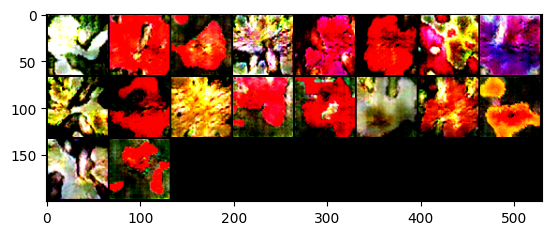

100%|██████████| 103/103 [00:09<00:00, 11.05it/s]


epoch: 35, lossD:0.3166637620300923, lossG:7.814743370685763,lossG_fake:4.186639758568366, lossG_real:3.6281036485746068 ,equality:0.5585361099937591


evaluate:113.78064727783203,kid_mean:0.0784074142575264, kid_std:0.04084416851401329,kid_:(tensor(0.0784), tensor(0.0408))


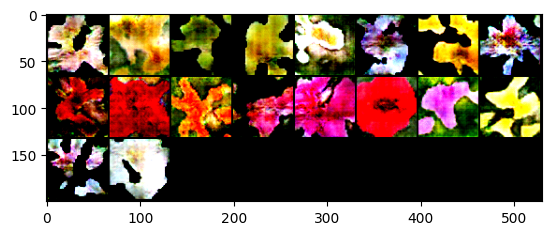

100%|██████████| 103/103 [00:09<00:00, 11.15it/s]


epoch: 36, lossD:0.26219920879139486, lossG:8.029416477795943,lossG_fake:4.300512157597588, lossG_real:3.7289043462392195 ,equality:0.5716078113583682


evaluate:108.11396789550781,kid_mean:0.07044215500354767, kid_std:0.04498712718486786,kid_:(tensor(0.0704), tensor(0.0450))


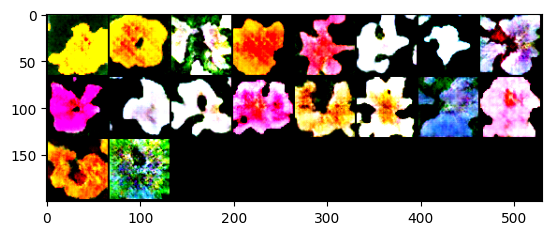

100%|██████████| 103/103 [00:09<00:00, 11.22it/s]


epoch: 37, lossD:0.19628334091524186, lossG:8.002669746435961,lossG_fake:4.316548500246214, lossG_real:3.68612124156026 ,equality:0.6304272586859541


evaluate:108.7930679321289,kid_mean:0.07871700078248978, kid_std:0.043106067925691605,kid_:(tensor(0.0787), tensor(0.0431))


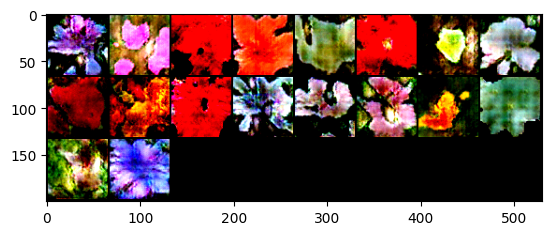

100%|██████████| 103/103 [00:09<00:00, 10.76it/s]


epoch: 38, lossD:0.22829303400392092, lossG:8.039247313749444,lossG_fake:4.269902730451046, lossG_real:3.7693445856131396 ,equality:0.5005581448379068


evaluate:108.2101821899414,kid_mean:0.07921817898750305, kid_std:0.040116168558597565,kid_:(tensor(0.0792), tensor(0.0401))


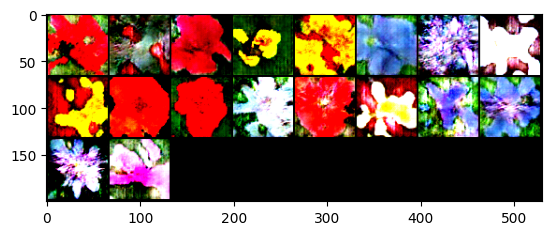

100%|██████████| 103/103 [00:09<00:00, 10.78it/s]


epoch: 39, lossD:0.24593090882651436, lossG:8.277495486065021,lossG_fake:4.412020606323353, lossG_real:3.8654748537008046 ,equality:0.5465457526225488


evaluate:104.81277465820312,kid_mean:0.07612402737140656, kid_std:0.04483865201473236,kid_:(tensor(0.0761), tensor(0.0448))


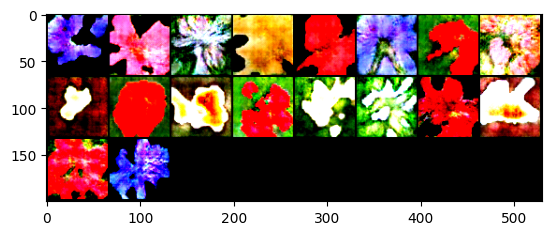

100%|██████████| 103/103 [00:09<00:00, 10.79it/s]


epoch: 40, lossD:0.2876999188865562, lossG:8.289496630140878,lossG_fake:4.448148907966984, lossG_real:3.8413477661540205 ,equality:0.6068011418129635


evaluate:99.31754302978516,kid_mean:0.06788570433855057, kid_std:0.038618069142103195,kid_:(tensor(0.0679), tensor(0.0386))


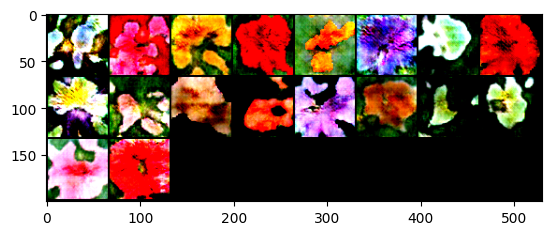

100%|██████████| 103/103 [00:09<00:00, 11.20it/s]


epoch: 41, lossD:0.2494872375888732, lossG:8.152427168725763,lossG_fake:4.392464228046751, lossG_real:3.759962949937987 ,equality:0.6325012781087636
evaluate:99.62400817871094,kid_mean:0.07604806125164032, kid_std:0.04046035557985306,kid_:(tensor(0.0760), tensor(0.0405))


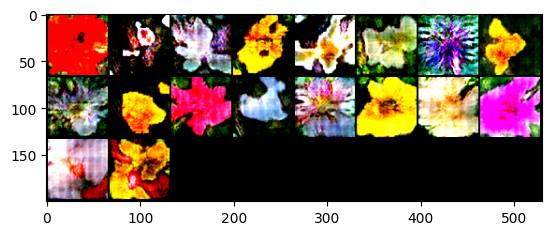

100%|██████████| 103/103 [00:09<00:00, 10.92it/s]


epoch: 42, lossD:0.20969420083735174, lossG:8.039491921952628,lossG_fake:4.209035919707956, lossG_real:3.8304559767824933 ,equality:0.3785799429254628


evaluate:97.04592895507812,kid_mean:0.06559685617685318, kid_std:0.04099281504750252,kid_:(tensor(0.0656), tensor(0.0410))


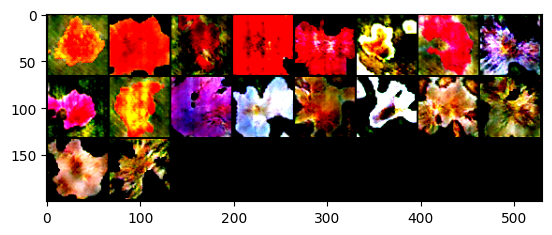

100%|██████████| 103/103 [00:09<00:00, 10.77it/s]


epoch: 43, lossD:0.2322688432211436, lossG:8.559557886956965,lossG_fake:4.647069358131261, lossG_real:3.9124884917898086 ,equality:0.7345808663414521


evaluate:98.0996322631836,kid_mean:0.07605583965778351, kid_std:0.040695011615753174,kid_:(tensor(0.0761), tensor(0.0407))


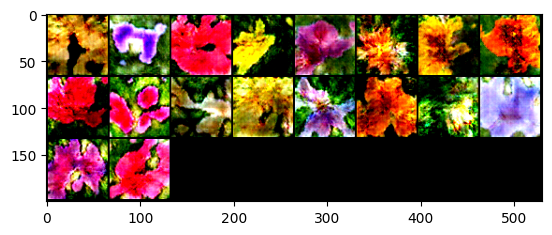

100%|██████████| 103/103 [00:09<00:00, 10.95it/s]


epoch: 44, lossD:0.3071162958891646, lossG:8.314941753461524,lossG_fake:4.4686985849176795, lossG_real:3.846243123695688 ,equality:0.6224554612219912


evaluate:98.97711944580078,kid_mean:0.0731850415468216, kid_std:0.03960355743765831,kid_:(tensor(0.0732), tensor(0.0396))


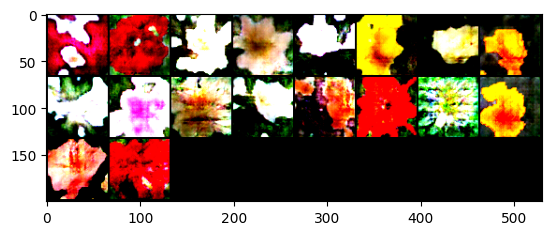

100%|██████████| 103/103 [00:09<00:00, 10.99it/s]


epoch: 45, lossD:0.1752870962819428, lossG:8.338083188510636,lossG_fake:4.444185167840383, lossG_real:3.893897997522817 ,equality:0.5502871703175662


evaluate:98.34522247314453,kid_mean:0.0727180689573288, kid_std:0.039440080523490906,kid_:(tensor(0.0727), tensor(0.0394))


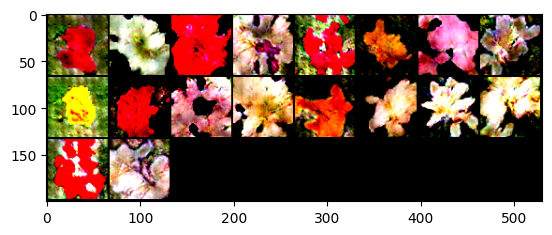

100%|██████████| 103/103 [00:09<00:00, 10.80it/s]


epoch: 46, lossD:0.26775697499368956, lossG:8.69443080031756,lossG_fake:4.6683365812579405, lossG_real:4.026094205749845 ,equality:0.6422423755080953


evaluate:96.84864044189453,kid_mean:0.07379426807165146, kid_std:0.045354973524808884,kid_:(tensor(0.0738), tensor(0.0454))


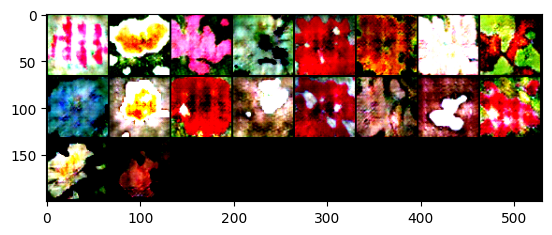

100%|██████████| 103/103 [00:09<00:00, 10.80it/s]


epoch: 47, lossD:0.20006017258517372, lossG:8.69254554822607,lossG_fake:4.622681071457354, lossG_real:4.069864511489868 ,equality:0.5528165599674857


evaluate:95.73973846435547,kid_mean:0.06964392960071564, kid_std:0.038717206567525864,kid_:(tensor(0.0696), tensor(0.0387))


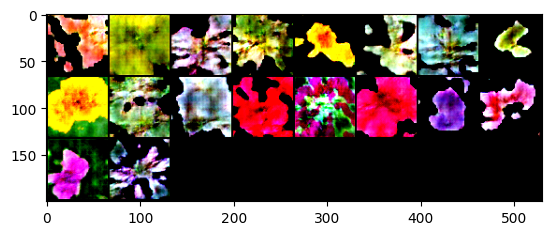

100%|██████████| 103/103 [00:09<00:00, 10.77it/s]


epoch: 48, lossD:0.24416139054573277, lossG:8.882128109052344,lossG_fake:4.792942512382582, lossG_real:4.0891855521109495 ,equality:0.7037569602716323


evaluate:95.09774017333984,kid_mean:0.06233559176325798, kid_std:0.04079621657729149,kid_:(tensor(0.0623), tensor(0.0408))


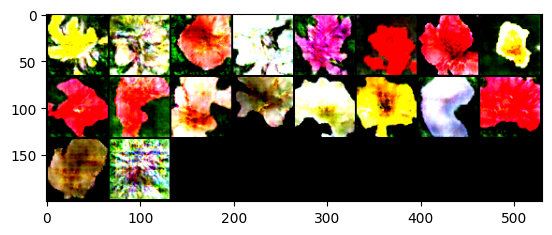

100%|██████████| 103/103 [00:09<00:00, 11.01it/s]


epoch: 49, lossD:0.2455861583641432, lossG:8.432708193954912,lossG_fake:4.512767858875608, lossG_real:3.9199403385514193 ,equality:0.5928275203241888


evaluate:94.66600036621094,kid_mean:0.08201692253351212, kid_std:0.041809726506471634,kid_:(tensor(0.0820), tensor(0.0418))


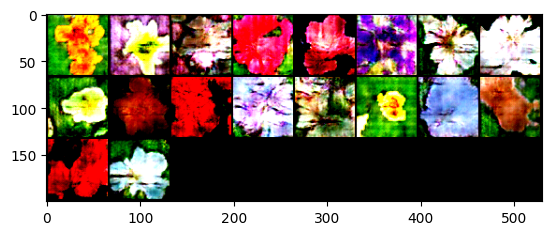

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

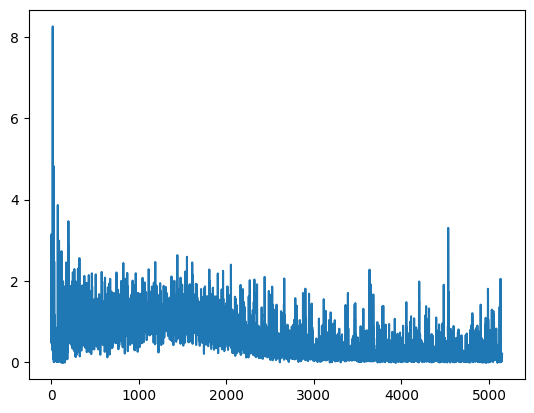

In [45]:
plt.plot(raw_lossesD)

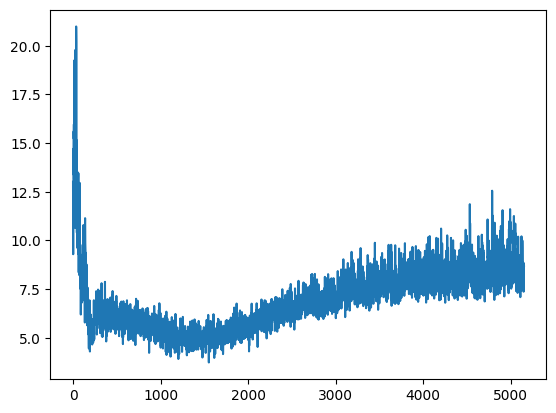

In [46]:
plt.plot(raw_lossesG)

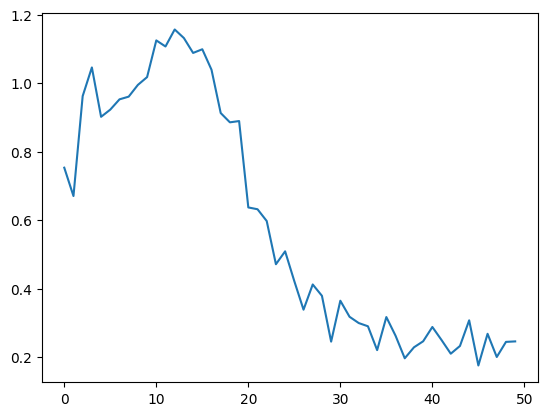

In [47]:
plt.plot(lossesD)

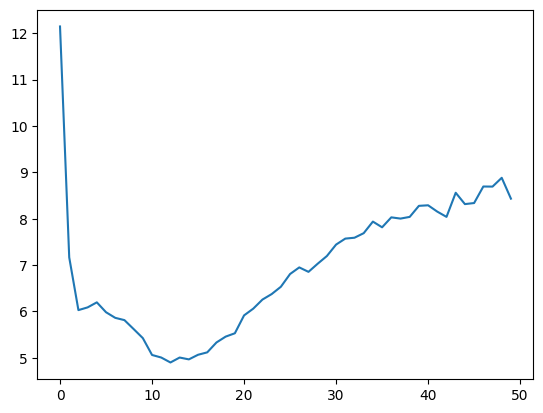

In [48]:
plt.plot(lossesG)

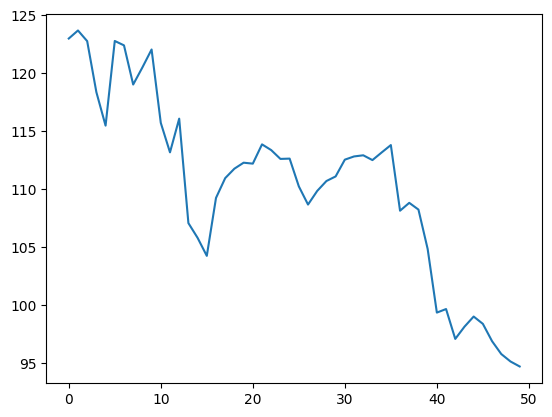

In [49]:
plt.plot(fid_)

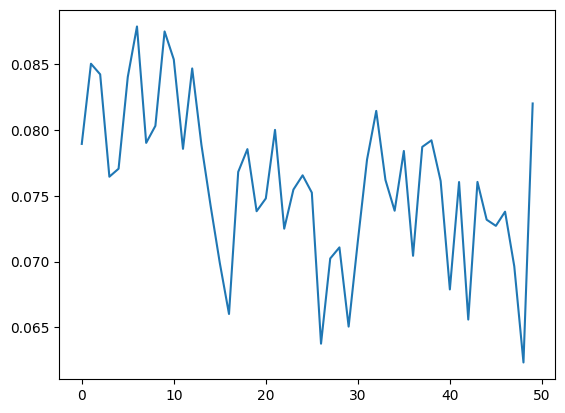

In [50]:
plt.plot(kid_mean_)

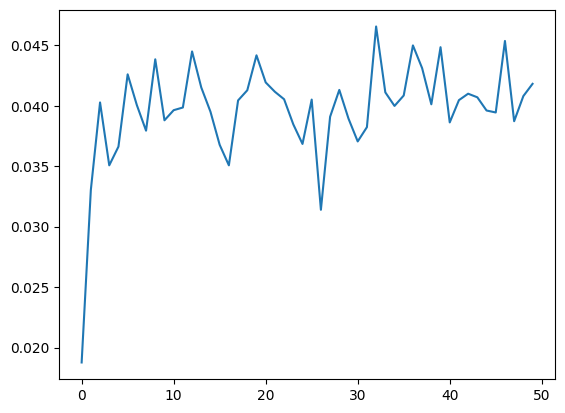

In [51]:
plt.plot(kid_std_)

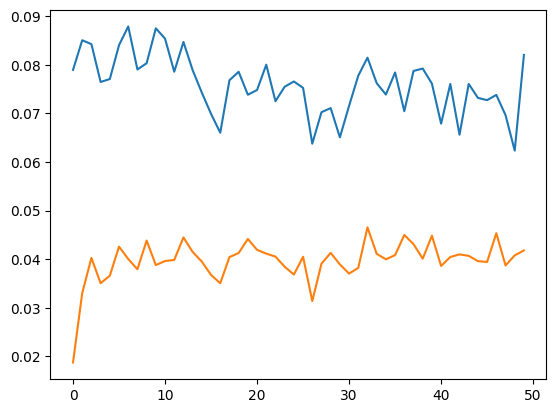

In [52]:
plt.plot(kid_score)

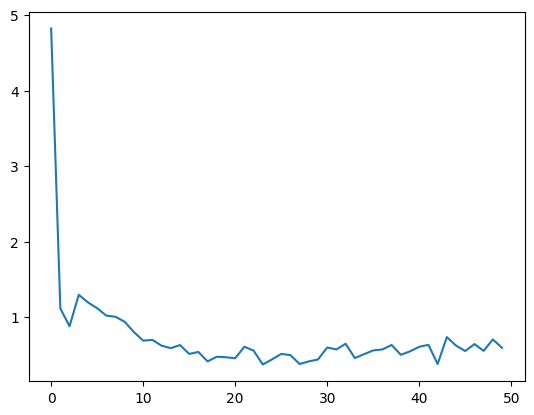

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0713), tensor(0.0436))